## Homework #6. Analyzing telegram channels about russian-ukrainian war
#### Author: Gryn Sofiia
#### Total time spent on h/w (in minutes): 1200

In this project we will perform analysis on pro-russian and pro-ukrainian telegram channels during russo-ukrainian war.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import os
import re
import matplotlib.pyplot as plt
import pymorphy2
%cd "D:\Мої документи\2 навч рік\1 трим\ОС\05Gryn\data\merged_data"
import warnings
warnings.filterwarnings('ignore')


In [ ]:
DIALOGS_MERGED_DATA_PATH = "../merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../merged_data/names.csv"
KEY_EVENTS_DATA_PATH = "../merged_data/KeyEvents.csv"
TONE_DICT_RU = "../merged_data/tone-dict-ru.csv"


In [ ]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH, low_memory=False)
keyevents = pd.read_csv(KEY_EVENTS_DATA_PATH, low_memory=False)
tone_dict = pd.read_csv(TONE_DICT_RU,low_memory=False)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
#cleaning dataset from garbage
df = df[(df.dialog_id <0) & (df.dialog_id != -1001124946559) & (df.dialog_id != -1001695318047) & (df.dialog_id != -1001146075551)]


In [ ]:
#removing unnecessary time
import datetime  
df['message'] = df['message'].astype('str') 
df['message'] = df['message'].str.lower()
#normal dtype of date
df['date'] =pd.to_datetime(df['date'], format = "%Y-%m-%d %H:%M:%S", errors='coerce').dt.tz_localize(None).dt.date
df['date'] = pd.to_datetime(df['date'])
df1 = df[df.date >= '2022-2-22']
df3 = df1.copy()
df3 = df1[df1.date >= '2022-3-15']




In [9]:
#replace ids with names
df1['dialog_id'] = df1['dialog_id'].replace(
    [-1001736895964, -1001708255880,-1001645788710,
     -1001583313036,-1001536630827,-1001535440128,
     -1001498939244,-1001472186202,-1001469021333,
     -1001386691094,-1001367599819,-1001360737249,
    -1001355540894,-1001345769364,-1001315735637,
    -1001315043344,-1001283359437,-1001281112385,
    -1001232032465,-1001227152968,-1001220606936,
    -1001198589840,-1001156935944,-1001153765346,
    -1001146075551,-1001101170442,-1001099737840,],
    ['война с фейками(ru)','Андрій Єрмак (ua)','Інсайдер (ua)'
    ,'АРХАНГЕЛ СПЕЦНАЗА Z(ru)','Лачен пише(ua)','Репортер Filatov(ru)'
    ,'Повёрнутые на Z войне (ru)','Мария Захарова(ru)','DeepState(ua)'
    ,'Телебачення Торонто(ua)','Неистовый мольберт ZOV(ru)','Скринька Пандори(ua)'
    ,'Операция Z: Военкоры Русской Весны(ru)','АНТОН ВЯЧЕСЛАВОВИЧ(ru)','СОЛОВЬЁВ(ru)'
    ,'ЦАПЛІЄНКО_UKRAINE FIGHTS(ua)','Vоенкор Котенок Z(ru)','Бабель(ua)'
    ,'УП. Стрічка(ua)','Маргарита Симоньян(ru)','STERNENKO(ua)'
    ,'Реальная Война(ua)','Радіо Свобода(ua)','political.ua(ua)'
    ,'InformNapalm(ua)','РИА Новости(ru)','Русская Весна Z(ru)'])

In [10]:
def mycountry(text):
    if "ua" in text:
        return "ua"
    else:
        return "ru"
    
df1["country"] = df1["dialog_id"].apply(lambda x: mycountry(x))

In [11]:
#creating  two different datasets with ukrainian and russian channels
values = [-1001708255880,-1001645788710,-1001536630827,-1001469021333,-1001386691094,-1001360737249,-1001315043344,
         -1001281112385,-1001232032465, -1001220606936, -1001198589840,-1001156935944, -1001153765346]
ua2 = df3.query("dialog_id in @values")
rus2 = df3.query("dialog_id not in @values")

Start analysing!)

## Part 1
## First glance

In [12]:
print("Amount of messages in russian channels is:",rus2.shape[0], ", and in ukrainian channels is:",ua2.shape[0])

Amount of messages in russian channels is: 157560 , and in ukrainian channels is: 134146


This is, indeed, a very interesting statistics, I thought, there would be much more messages in ukrainian channels, as we have tons of messages like "*місто*, повітряна тривога" or "*місто*,вибухи", russians don't have that, but still they post much much more. Now let's look at some basic information about mixed data.

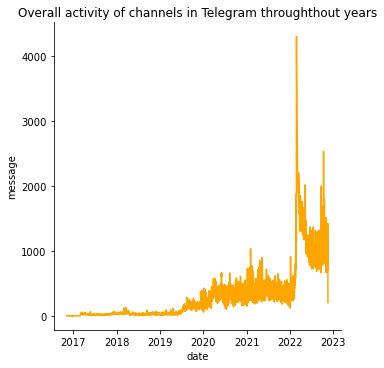

In [14]:
activity = df[["date", "message"]].groupby("date").count()
sns.relplot("date", "message", data = activity, kind = "line",palette='bright', color='orange', ci = None ).set(title = "Overall activity of channels in Telegram throughthout years" )

We have to say that not all channels existed before the war, but still it is easy to see how life divided for "before" and "after". Now let's look a bit closer at the channels and activity.

In [15]:
df_var = df1.copy()
df_var["message"] =1
df_n = df_var[['dialog_id','type','message','country']].groupby([pd.Categorical(df_var.message),'dialog_id','type'], as_index=False).count().fillna(0)
photo = list(df_n.loc[df_n['type'] == 'photo']['message'])
text = list(df_n.loc[df_n['type'] == 'text']['message'])
video = list(df_n.loc[df_n['type'] == 'video']['message'])
voice = list(df_n.loc[df_n['type'] == 'voice']['message'])
sticker = list(df_n.loc[df_n['type'] == 'sticker']['message'])
chats = df_n['dialog_id'].unique()
new_df = pd.DataFrame(list(zip(chats, photo, text, video, voice, sticker)),columns =['dialog_id','photo', 'text','video', 'voice', 'sticker'])
new_df["country"] = new_df["dialog_id"].apply(lambda x: mycountry(x))
new_df.set_index('dialog_id')
new_df['total'] = new_df[['photo', 'text','video','voice', 'sticker']].sum(axis=1)
new_df = new_df.assign(vid_perc=lambda x: (x['video'] * 100/ x['total']))
new_df = new_df.sort_values(by='vid_perc', ascending = False)

In [16]:
df_var1 = df_var[['date','dialog_id','type','message']].groupby([pd.Categorical(df_var.message),'date','dialog_id','type'], as_index=False).count().fillna(0)
df_var1["country"] = df_var1["dialog_id"].apply(lambda x: mycountry(x))
df_var1 = df_var1.loc[(df_var1['type'] == 'video')| (df_var1['type'] == 'photo') | (df_var1['type'] == 'text')]

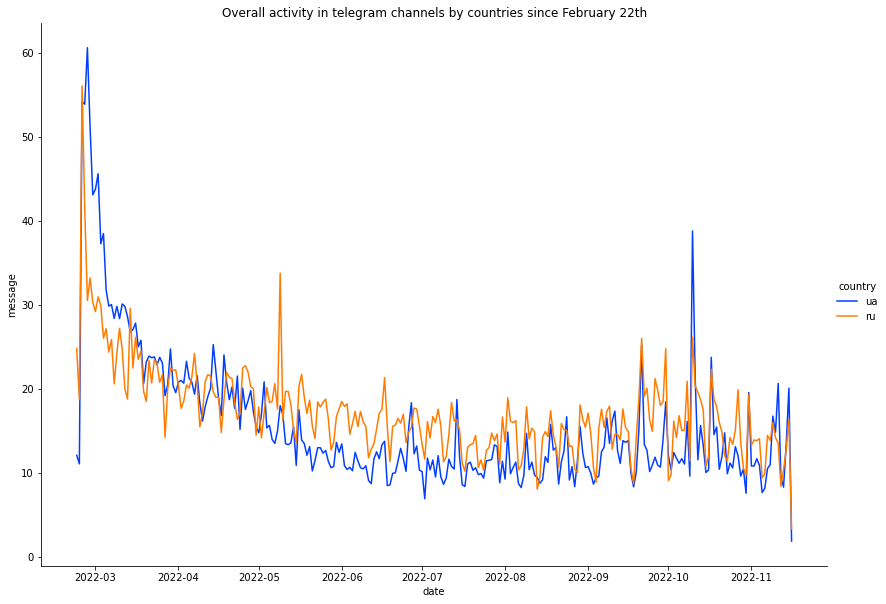

In [15]:
sns.relplot("date", "message", data = df_var1, kind = "line", hue = "country",palette='bright', height=8.27, aspect=11.7/8.27, ci = None ).set(title = "Overall activity in telegram channels by countries since February 22th")

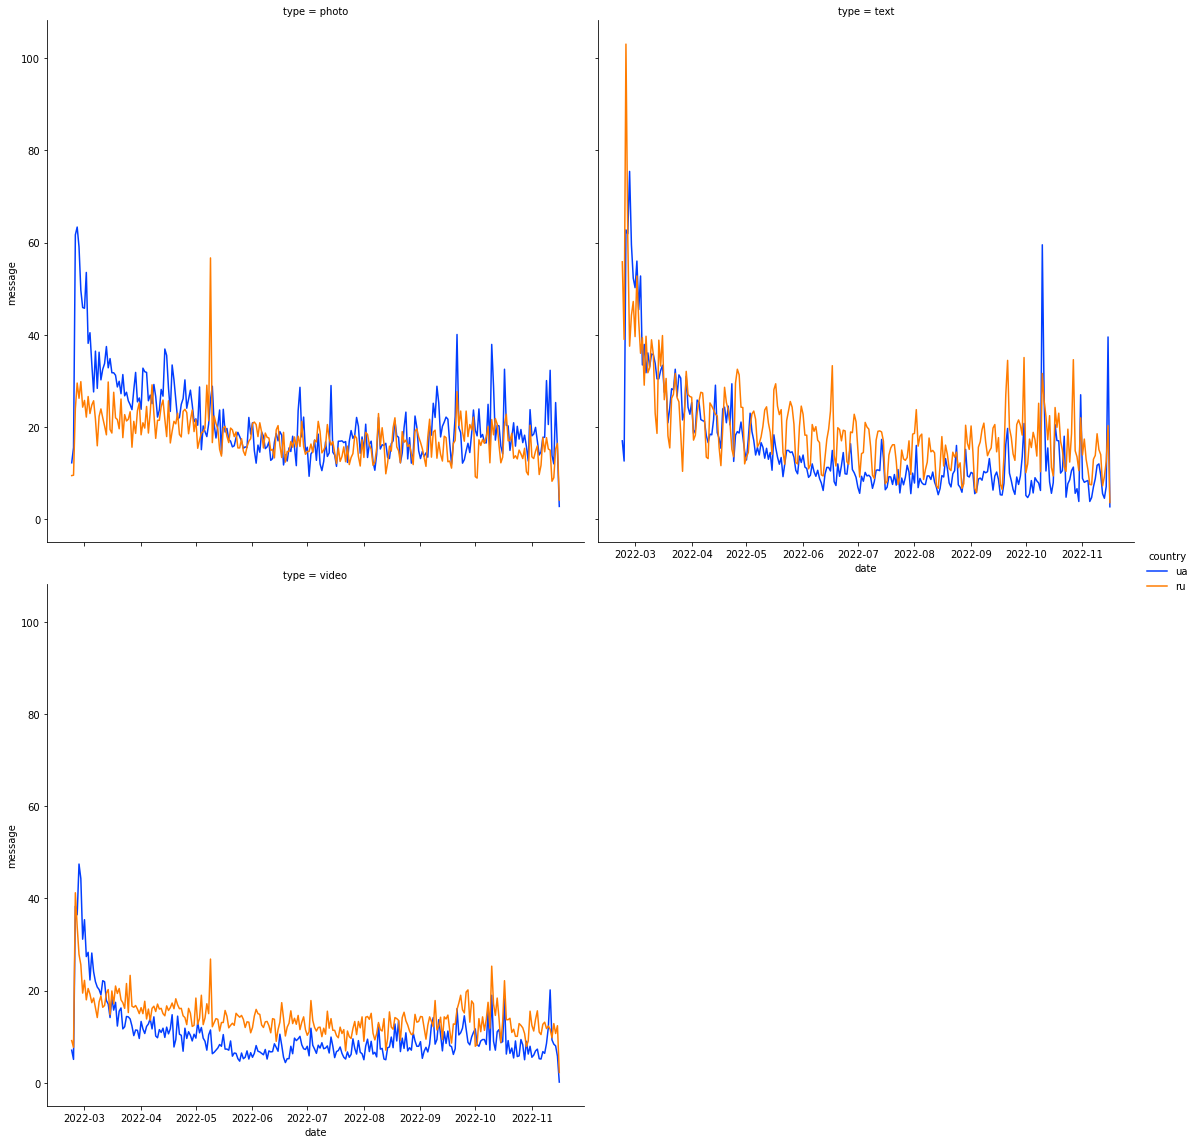

In [16]:
sns.relplot("date", "message", data = df_var1, kind = "line", col = "type", col_wrap = 2, hue = "country",palette='bright', height=8, aspect=1, ci = None )

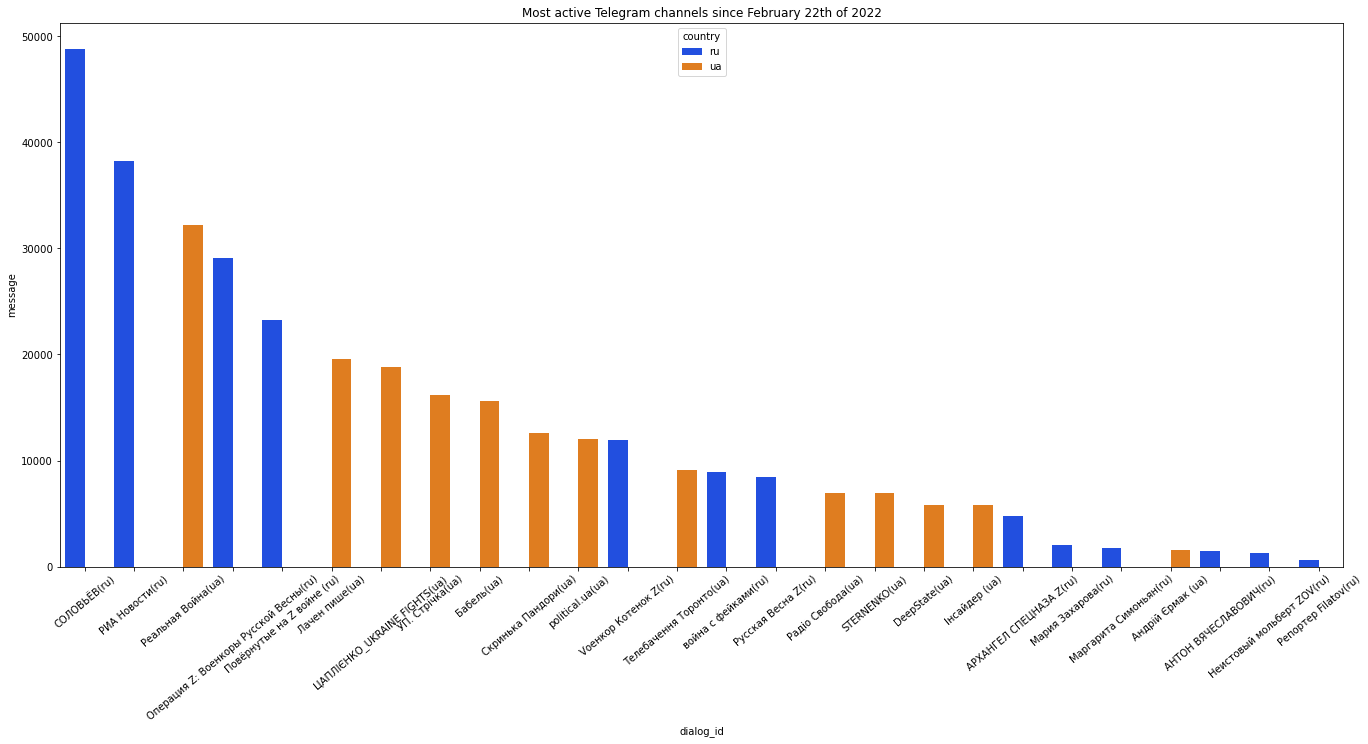

In [17]:
activity = df1[["message", "dialog_id", "country"]].groupby(["dialog_id", "country"], as_index=False).count()
activity = activity.sort_values(by='message', ascending = False)
activity.head()
fig, ax = plt.subplots(figsize=(23,10))
sns.barplot(data=activity, x="dialog_id", y="message", hue = "country", palette='bright').set(title = "Most active Telegram channels since February 22th of 2022")
plt.xticks(rotation=40);
activity.to_csv(r'D:\Мої документи\2 навч рік\1 трим\ОС\05Gryn\activity1.csv', index = False)


[Text(0.5, 1.0, ' Overall distribution between types ')]

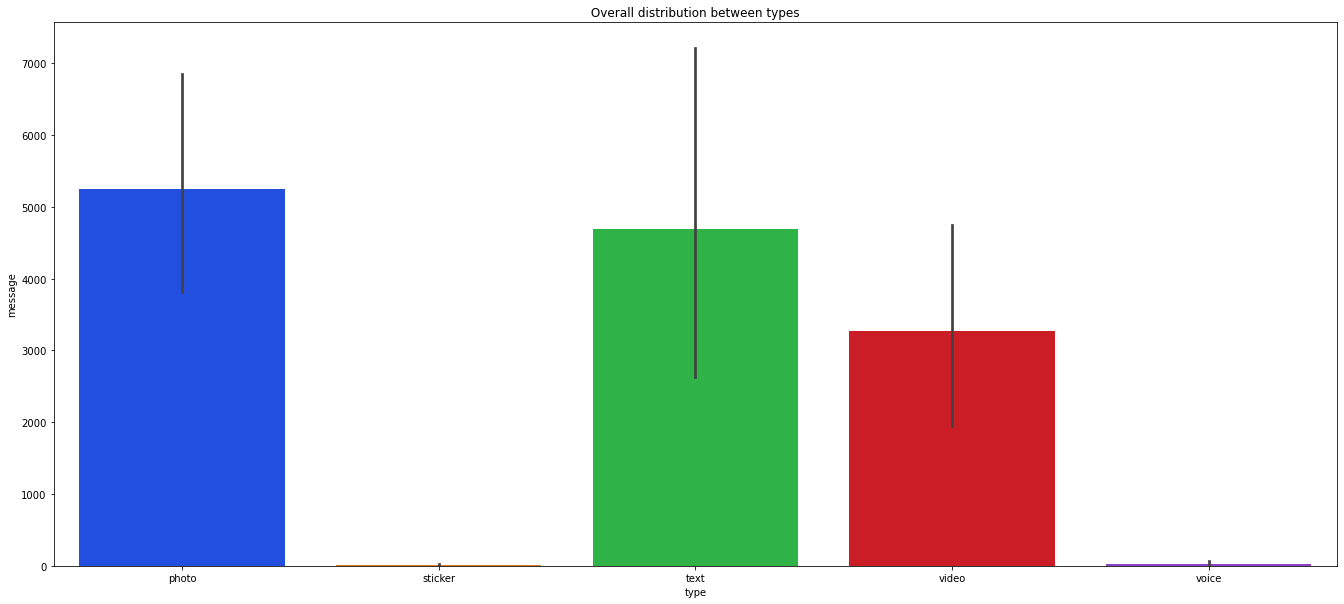

In [18]:
df2 = df1[['message','type','country','dialog_id']].groupby(["type", 'dialog_id','country'], as_index = False)['message'].agg('count')
fig, ax = plt.subplots(figsize=(23,10))
sns.barplot(data=df2, x="type", y="message",palette='bright').set(title = " Overall distribution between types ")

Here we can see distribution of the types of posts. Interesting how photo type is on the first place. Telegram is mostly used for written posts, but channels like to put photos to show some proof to their words. What is even more interesting - video messages - 24.7%. I did not expect such distribution, let's check what country and what channels post so many videos.

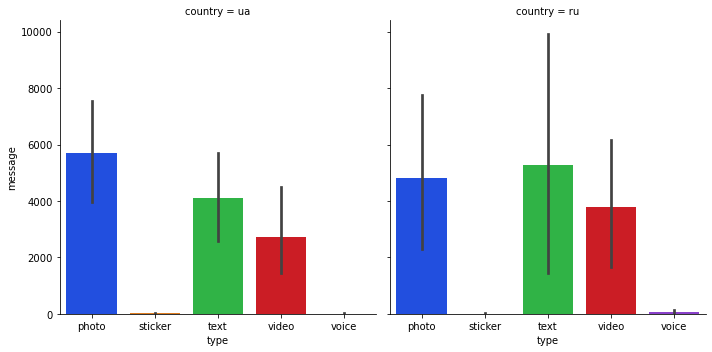

In [19]:
sns.catplot(data=df2, x="type", y="message",palette='bright', col ='country', kind = 'bar')

Interesting to see that Ukraine has more photos than texts, even though, as I told before, hundreds of messages about explotions and air sirens at first glance should outlarge amount of photo posts, but they really aren't.

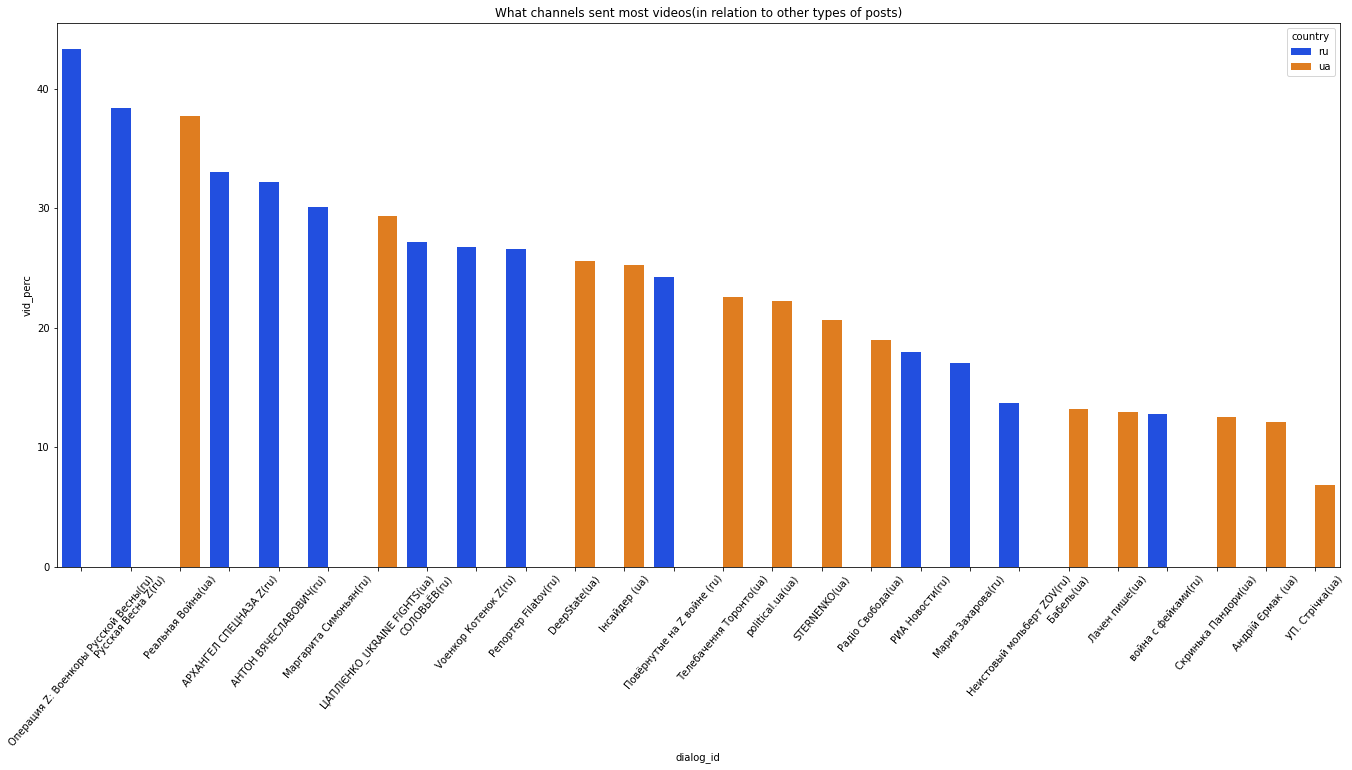

In [20]:
fig, ax = plt.subplots(figsize=(23,10))
sns.barplot(data=new_df, x="dialog_id", y="vid_perc",hue = 'country', palette = 'bright').set(title = "What channels sent most videos(in relation to other types of posts)")
plt.xticks(rotation=50);

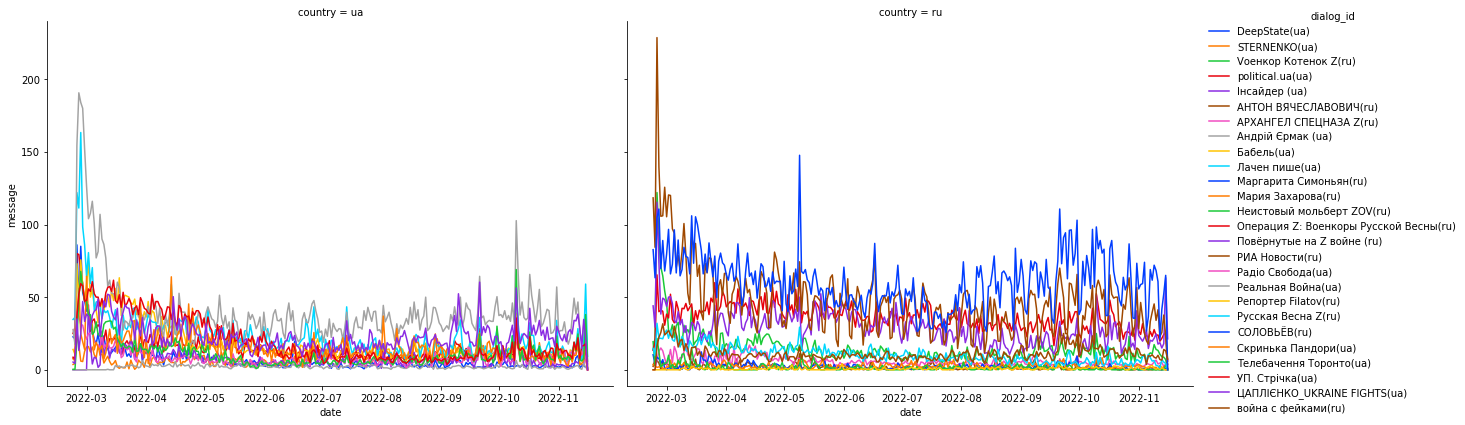

In [21]:
sns.relplot("date", "message", data = df_var1, kind = "line", hue = "dialog_id", col = 'country',palette='bright', height=6, aspect=11.7/8.27, ci = None )

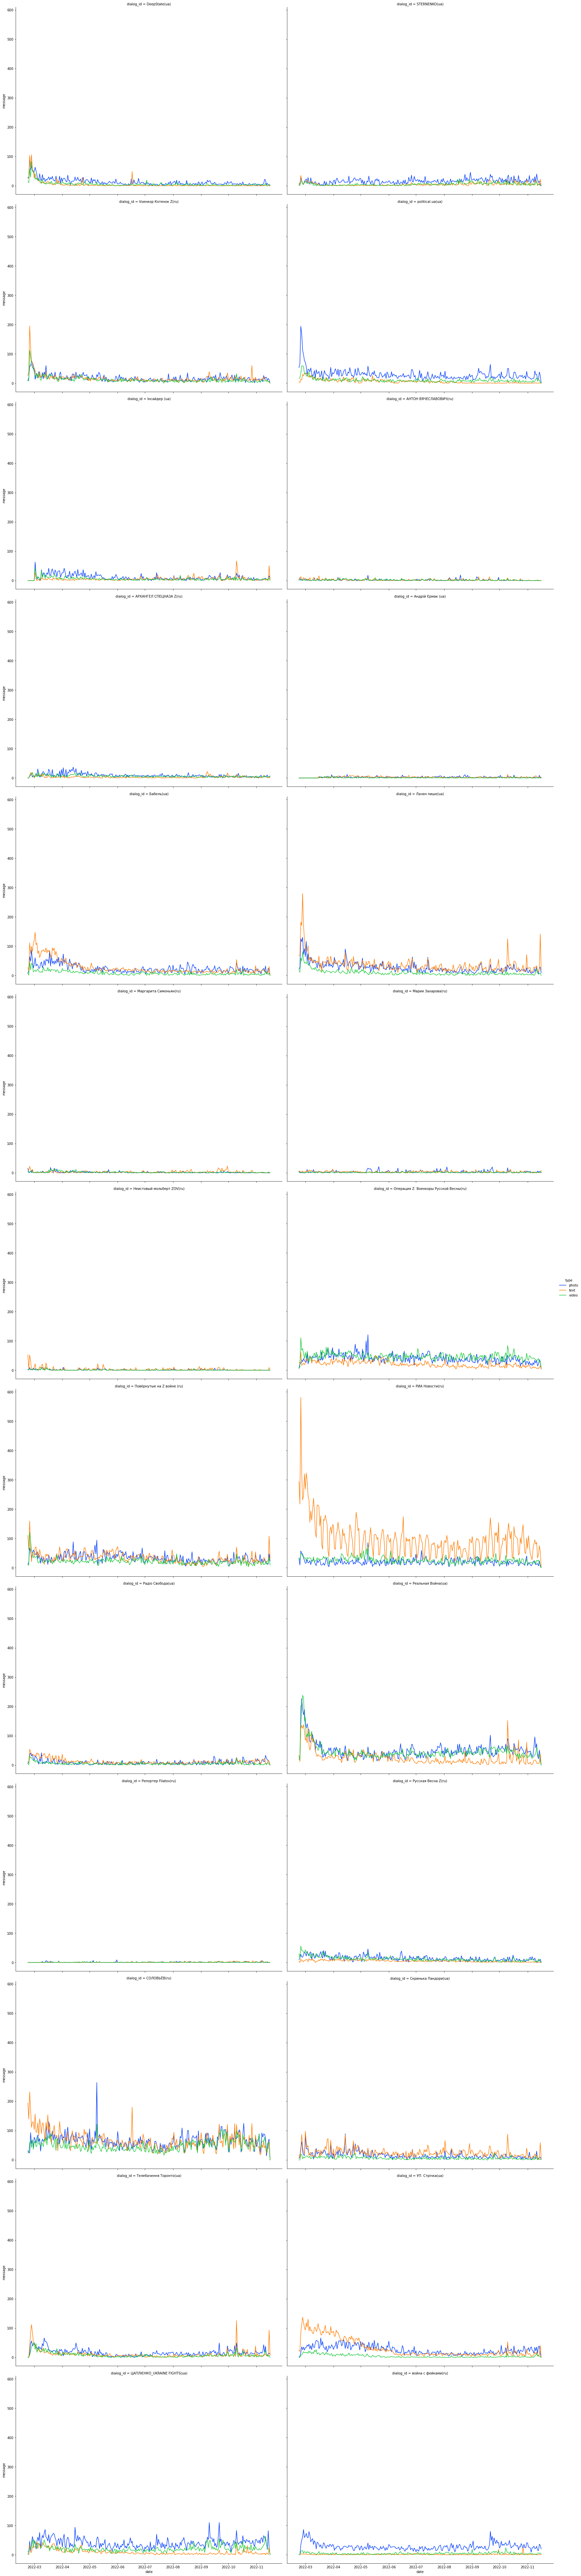

In [22]:
sns.relplot("date", "message", data = df_var1, kind = "line", hue = "type", col = 'dialog_id', col_wrap = 2,palette='bright', height=8.27, aspect=11.7/8.27, ci = None )

Interesting to see how each channel has it's own unique pattern. For example РИА Новости, УП.Стрічка and Реальная война are absolutely unique and uncomparable.

Now let's have a closer look on the channels. For better visualization we will remove first month of the war, as it was hyper-active, and we will look closer at the existing peaks and events that were behind them

## Part 2
## Closer look at the channels 

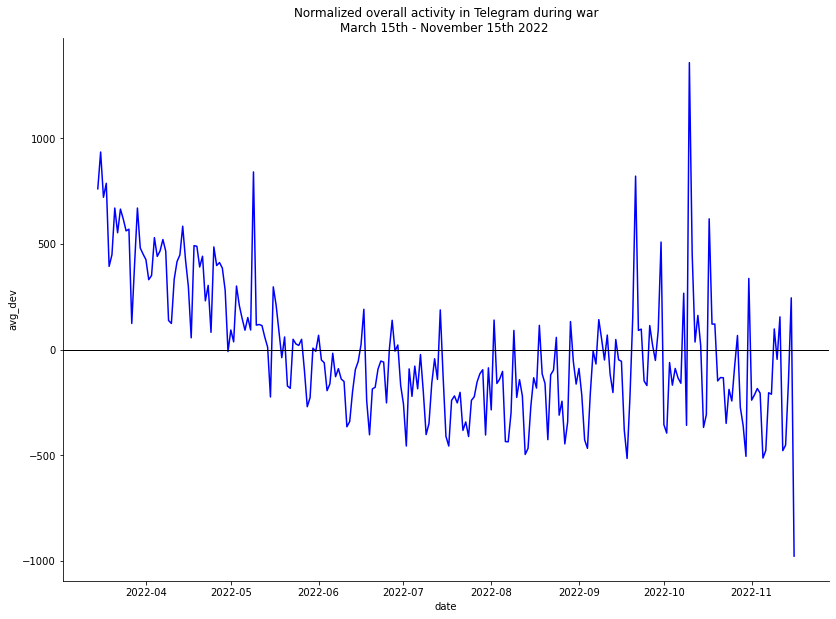

In [23]:
df3.head()
activity1 = df3[["date", "message"]].groupby("date").count()
average = int(activity1['message'].sum()/activity1.count())
activity1 = activity1.assign(avg_dev=lambda x: (x['message'] - average))

g = sns.relplot("date", 'avg_dev',data = activity1, kind = 'line', color='blue', height=8.27, aspect=11.7/8.27).set( title="Normalized overall activity in Telegram during war\nMarch 15th - November 15th 2022 ")

plt.axhline(0, ls='-', linewidth=1, color='k')

plt.show()



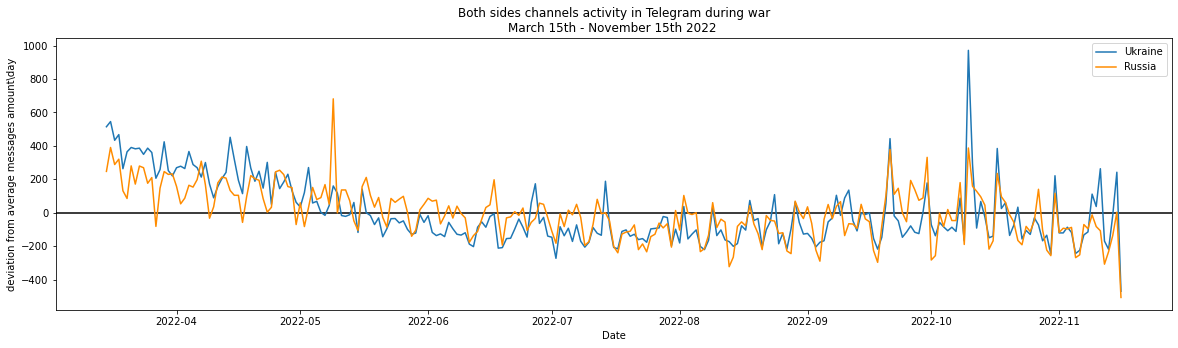

In [24]:
uaactivity = ua2[["date", "message"]].groupby("date").count()
rusactivity = rus2[["date", "message"]].groupby("date").count()
averageua = int(uaactivity['message'].sum()/uaactivity.count())
averagerus = int(rusactivity['message'].sum()/rusactivity.count())
uaactivity = uaactivity.assign(avg_dev=lambda x: (x['message'] - averageua))
rusactivity = rusactivity.assign(avg_dev=lambda x: (x['message'] - averagerus))
fig, ax = plt.subplots(figsize=(20,5))
ax.axhline(y=0, color='k')
ax.plot(uaactivity.index,uaactivity["avg_dev"], label = "Ukraine")
ax.plot(rusactivity.index,rusactivity["avg_dev"], 'darkorange', label = "Russia")
ax.legend(loc="upper right")
ax.set(xlabel="Date",
       ylabel="deviation from average messages amount\day",
       title="Both sides channels activity in Telegram during war\nMarch 15th - November 15th 2022 ")
plt.show()

Interesting reaction here. Not all chosen channels are fully dedicated to the war, we have news channels, propagandists, some officials' pages, but nevertheless, activities of both countries' channels correspond to each other. So we may come to conclusion, that all channels are triggered by same events(that may sound obvious, but let's not forget that for Russia, war is a so-called special opperation, and they always try to add their normal news about life, Europe and other staff, but looks like that main subject is still Ukraine). Now, let's highlight some peaks and investigate what happened at those days.

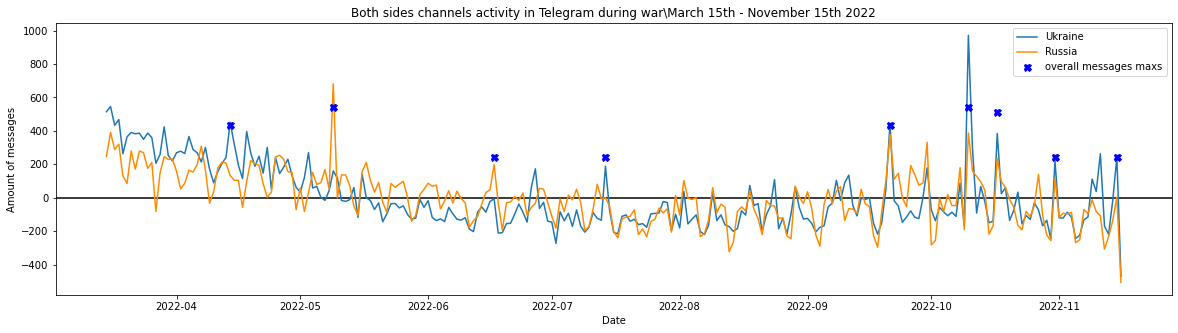

In [25]:
dif = 21
peak1 =30
peak2 = 55
peak3 = 94
peak4 = 121
peak5 =190
peak6= 209
peak8= 230
peak10= 245
peak11= 216
peak12 = 241
peak13 = 104
peak14 = 216
fig, ax = plt.subplots(figsize=(20,5))
ax.axhline(y=0, color='k')
ax.plot(uaactivity.index,uaactivity["avg_dev"],  label = "Ukraine")
ax.plot(rusactivity.index,rusactivity["avg_dev"], 'darkorange', label = "Russia" )
ax.plot(uaactivity.index[peak1], uaactivity["avg_dev"][2], 'bX', markersize=7, label = "overall messages maxs")
ax.plot(uaactivity.index[peak2], uaactivity["avg_dev"][1], 'bX', markersize=7)
ax.plot(uaactivity.index[peak3], uaactivity["avg_dev"][-2], 'bX', markersize=7)
ax.plot(uaactivity.index[peak4], uaactivity["avg_dev"][-2], 'bX', markersize=7)
ax.plot(uaactivity.index[peak5], uaactivity["avg_dev"][2], 'bX', markersize=7)
ax.plot(uaactivity.index[peak6], uaactivity["avg_dev"][1], 'bX', markersize=7)
ax.plot(uaactivity.index[peak8], uaactivity["avg_dev"][-2], 'bX', markersize=7)
ax.plot(uaactivity.index[peak10], uaactivity["avg_dev"][-2], 'bX', markersize=7)
ax.plot(uaactivity.index[peak11], uaactivity["avg_dev"][0], 'bX', markersize=7)
ax.legend(loc="upper right")
ax.set(xlabel="Date",
       ylabel="Amount of messages",
       title="Both sides channels activity in Telegram during war\March 15th - November 15th 2022")
plt.show()

Let's browse our new dataset "Key events of the war" and have a closer look on what happened those days

In [26]:
keyevents.head(5)

,war_date,events
0,2/22/2022,"official recognition of the so-called ""LPR"" an..."
1,2/23/2022,hacker attack on Ukrainian governmental sites
2,2/24/2022,start of the war
3,2/25/2022,"most of the Kyiv region is occupied, Chernihiv..."
4,2/26/2022,"Fights in Kyiv city, massive bombardings of Ky..."


In [27]:
pk1 = uaactivity.index[peak1].date()
pk2 = uaactivity.index[peak2].date()
pk3 = uaactivity.index[peak3].date()
pk4 = uaactivity.index[peak4].date()
pk5 = uaactivity.index[peak5].date()
pk6 = uaactivity.index[peak6].date()
pk8 = uaactivity.index[peak8].date()
pk10 = uaactivity.index[peak10].date()
pk11 = uaactivity.index[peak11].date()
print("Date of peak1 is:",pk1,"\nThe event is:",keyevents._get_value(keyevents.index[peak1+dif],"events"),
"\nDate of peak2 is:",pk2,"\nThe event is:",keyevents._get_value(keyevents.index[peak2+dif],"events"),
"\nDate of peak3 is:",pk3,"\nThe event is:",keyevents._get_value(keyevents.index[peak3+dif],"events"),
"\nDate of peak4 is:",pk4,"\nThe event is:",keyevents._get_value(keyevents.index[peak4+dif],"events"))

Date of peak1 is: 2022-04-14 
The event is: battleship "Moscow" sanks 
Date of peak2 is: 2022-05-09 
The event is: Victory day, very important and symbolic for Russians 
Date of peak3 is: 2022-06-17 
The event is: 4 EU leaders visit Ukraine, showing their support 
Date of peak4 is: 2022-07-14 
The event is: nan


In [28]:
print("Date of peak5 is:",pk5,"\nThe event is:",keyevents._get_value(keyevents.index[peak5+dif],"events"),
"\nDate of peak6 is:",pk6,"\nThe event is:",keyevents._get_value(keyevents.index[peak6+dif],"events"),
"\nDate of peak7 is:",pk8,"\nThe event is:",keyevents._get_value(keyevents.index[peak8+dif],"events"),
"\nDate of peak8 is:",pk10,"\nThe event is:",keyevents._get_value(keyevents.index[peak10+dif],"events"),
"\nDate of peak9 is:",pk11,"\nThe event is:",keyevents._get_value(keyevents.index[peak11+dif],"events"))

Date of peak5 is: 2022-09-21 
The event is: Captive exchange: 255 Azovstal defenders for 55 russian soldiers and Viktor Medvedchuck 
Date of peak6 is: 2022-10-10 
The event is: Massive autumn bombarding of Ukraine  using Iranian drones "Shahed" 
Date of peak7 is: 2022-10-31 
The event is: Massive autumn bombarding of Ukraine 
Date of peak8 is: 2022-11-15 
The event is:  Massive autumn bombarding of Ukraine 
Date of peak9 is: 2022-10-17 
The event is: Kyiv harshly bombed


Pleasure to see here news about Azovstal and battleship 'Moscow', and not only bombardings. 

Now let's check if most popular words correspond to the events and war in general, to prove that it is not a coincidence or it's not connected to other topics

In [29]:
#4
peak1ua = ua2.loc[ua2["date"] == '2022-4-14']
peak2rus = rus2.loc[rus2["date"] == '2022-06-17']
peak3ua = ua2.loc[ua2["date"]== '2022-10-10']
peak4rus =  rus2.loc[rus2["date"] == '2022-05-09']
peak5ua = ua2.loc[ua2['date']== '2022-09-21']

peak1ual = peak1ua["message"].tolist()
peak2rusl = peak2rus["message"].tolist()
peak3ual = peak3ua["message"].tolist()
peak4rusl = peak4rus["message"].tolist()
peak5ual = peak5ua['message'].tolist()

peak1uastr = ' '.join(peak1ual)
peak2russtr = ' '.join(peak2rusl)
peak3uastr = ' '.join(peak3ual)
peak4russtr = ' '.join(peak4rusl)
peak5uastr = ' '.join(peak5ual)



In [30]:
def remove_symbols(data):
    emoj = re.compile("["
                    "\d"
                 "(.;‼:@|}\"\'\«\»/,*\\!)*?"
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
peak1uastr = remove_symbols(peak1uastr)
peak2russtr = remove_symbols(peak2russtr)
peak3uastr = remove_symbols(peak3uastr)
peak4russtr = remove_symbols(peak4russtr)
peak5uastr = remove_symbols(peak5uastr)



In [31]:
from nltk.tokenize import word_tokenize

tokenp1ua = word_tokenize(peak1uastr)
tokenp2rus = word_tokenize(peak2russtr)
tokenp3ua = word_tokenize(peak3uastr)
tokenp4rus = word_tokenize(peak4russtr)
tokenp5ua = word_tokenize(peak5uastr)
stoppers = {'в','по','до',"сих","пор","political.ua", "которое",'а','та','що','на','о',')','(','—','–','’','не','його','%','з','у','для','і',"путіна"
           ,'від','це','над','то','дійсно','будуть','наприклад','але','їх','ви','ми','буде','#',''
           ,'нам','поки','адже','-','и','от','но','із','его','такие','об','нас','этом','с','что','він',"вони", "он",
            'из-за','за','є','про','ещё','очень','они','я','то','дуже','які','подпишись',"были", "будут", "после", "після",'около',"близько", "приблизно",
           'підпишись','канал','всі','все','ні','нет','nan','як','из','к','это','під','якщо','вас','вже',
           'реальная',';','tmervvoenkor','🇺🇦реальная','ще','також','как','чтобы', "сообщают", "во","сначала","в","который",
         "уже", "politicalua", "подпишись", "ты", "этого", "сейчас","жаль", "лише", "яке", "на жаль", "постят", "почему",
             "почему-то", "cоловьёв live", "навряд","мне","так", "то", "вот", "исходя", "был","заявила", "заявил", "ой",
             "кавуняча", "кавунова", "кавун","хотят", "хочет","всё", "как", "мы", "факт", "долгий", "год","рассказали","также","только", "под","хто","тому", "появились",
            "появился"}



In [32]:
filtered1 = []
filtered2 = []
filtered3 = []
filtered4 = []
filtered5 = []
for w in tokenp1ua:
    if w not in stoppers:
        filtered1.append(w)
for w in tokenp2rus:
    if w not in stoppers:
        filtered2.append(w)
for w in tokenp3ua:
    if w not in stoppers:
        filtered3.append(w)
for w in tokenp4rus:
    if w not in stoppers:
        filtered4.append(w)
for w in tokenp5ua:
    if w not in stoppers:
        filtered5.append(w)

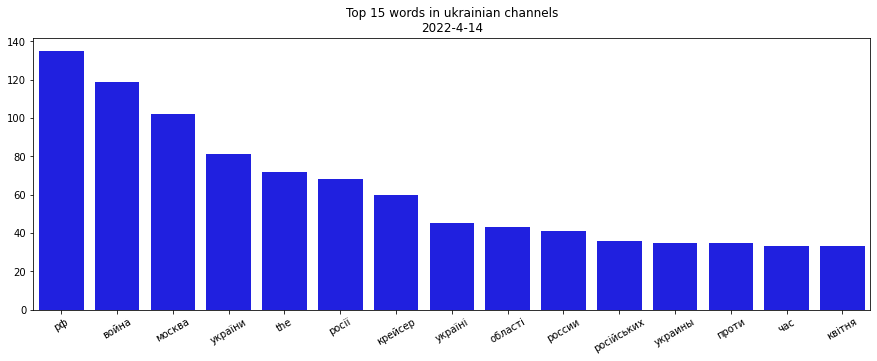

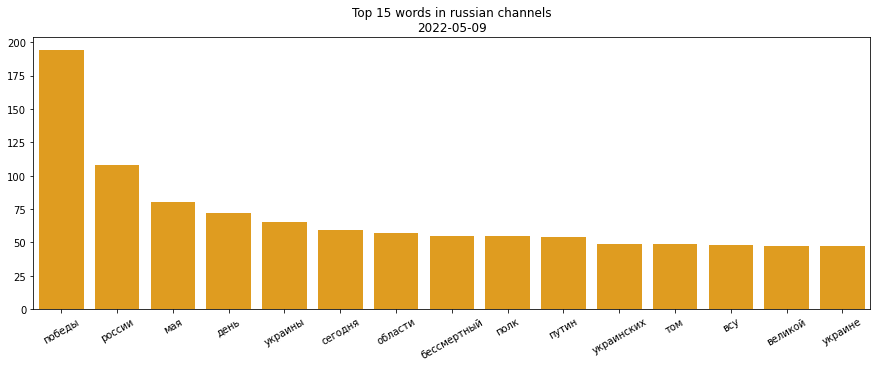

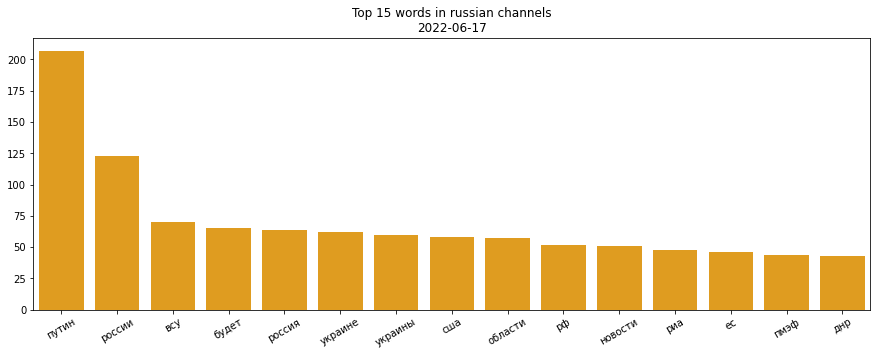

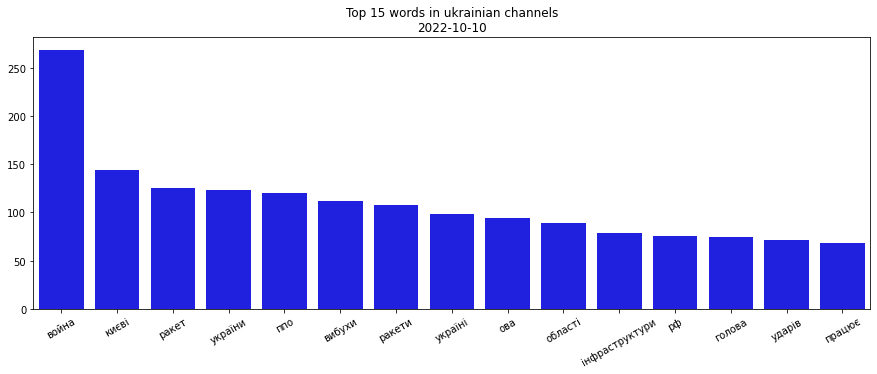

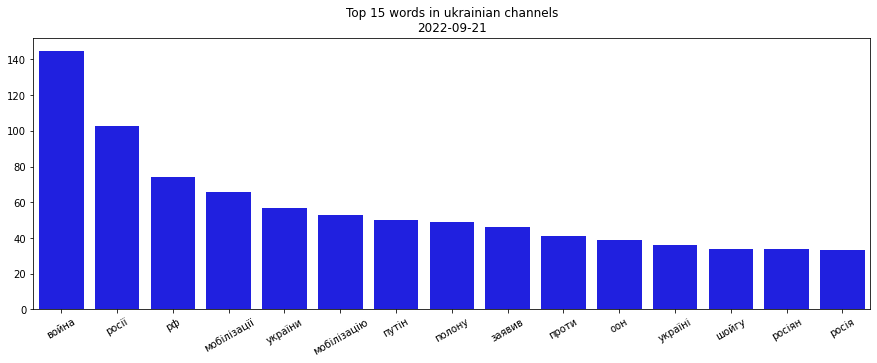

In [33]:
from nltk.probability import FreqDist
topua1 = FreqDist(filtered1).most_common(15)
topua1 = pd.Series(dict(topua1))

toprus2 = FreqDist(filtered2).most_common(15)
toprus2 = pd.Series(dict(toprus2))

topua3 = FreqDist(filtered3).most_common(15)
topua3 = pd.Series(dict(topua3))

toprus4 = FreqDist(filtered4).most_common(15)
toprus4 = pd.Series(dict(toprus4))

topua5 = FreqDist(filtered5).most_common(15)
topua5 = pd.Series(dict(topua5))

fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=topua1.index, y=topua1.values, ax=ax,  color= "blue").set(title='Top 15 words in ukrainian channels\n2022-4-14')
plt.xticks(rotation=30);

fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=toprus4.index, y=toprus4.values, ax=ax, color= "orange").set(title='Top 15 words in russian channels\n2022-05-09')
plt.xticks(rotation=30);


fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=toprus2.index, y=toprus2.values, ax=ax,color= "orange").set(title='Top 15 words in russian channels\n2022-06-17')
plt.xticks(rotation=30);

fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=topua3.index, y=topua3.values, ax=ax, color= "blue").set(title='Top 15 words in ukrainian channels\n2022-10-10')
plt.xticks(rotation=30);

fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=topua5.index, y=topua5.values, ax=ax,color= "blue").set(title='Top 15 words in ukrainian channels\n2022-09-21')
plt.xticks(rotation=30);





We totally see that most frequent words match the topics, so the peaks are correct and our assumptions too. Now, we already saw that overall distribution between types was unpredictable and even strange, so let's try to check distribution not overall, but for types, in particular videos and photos.

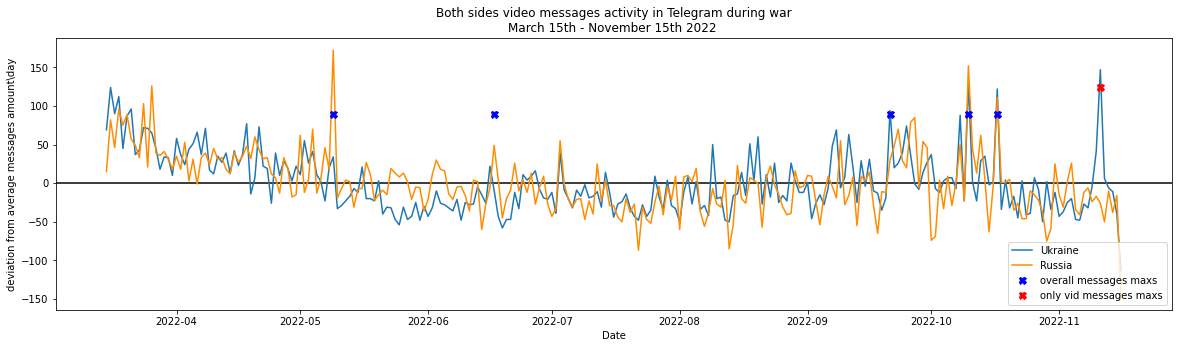

In [34]:
vidua = ua2.loc[ua2["type"]=="video"]
vidrus = rus2.loc[rus2["type"] =="video"]

vid_uaact = vidua[["date", "message"]].groupby("date").count()
average_vidua = int(vid_uaact['message'].sum()/vid_uaact.count())

vid_rusact = vidrus[["date", "message"]].groupby("date").count()
average_vidrus = int(vid_rusact['message'].sum()/vid_rusact.count())

vid_uaact = vid_uaact.assign(avg_dev=lambda x: (x['message'] - average_vidua))
vid_rusact = vid_rusact.assign(avg_dev=lambda x: (x['message'] - average_vidrus))

fig, ax = plt.subplots(figsize=(20,5))
ax.axhline(y=0, color='k')
ax.plot(vid_uaact.index,vid_uaact["avg_dev"], label = "Ukraine")
ax.plot(vid_rusact.index,vid_rusact["avg_dev"], 'darkorange', label = "Russia")
ax.set(xlabel="Date",
       ylabel="deviation from average messages amount\day",
       title="Both sides video messages activity in Telegram during war\nMarch 15th - November 15th 2022 ")



ax.plot(vid_uaact.index[peak2], vid_uaact["avg_dev"][2], 'bX', markersize=7, label = "overall messages maxs")
ax.plot(vid_uaact.index[peak3], vid_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(vid_uaact.index[peak5], vid_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(vid_uaact.index[peak6], vid_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(vid_uaact.index[peak11], vid_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(vid_uaact.index[peak12], vid_uaact["avg_dev"][1], 'bX', color = 'r', markersize=7, label = "only vid messages maxs")
ax.legend(loc="lower right")
plt.show()

Mostly, video messages peaks correspond to overall peaks(they are marked as blue crosses), but we have one more large peak(actually, the largest one for Ukraine), it is marked with a red cross. Let's browse the event.

In [35]:
pk12 = uaactivity.index[peak12].date()
print("Date of peak12 is:",pk12,"\nThe event is:",keyevents._get_value(keyevents.index[peak12+dif],"events"))

Date of peak12 is: 2022-11-11 
The event is: Antonivskiy bridge is destroyed, Kherson is deoccupied


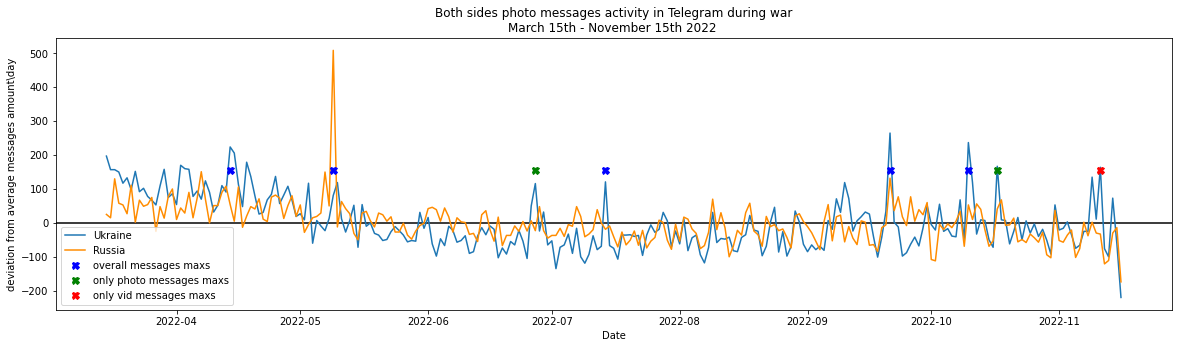

In [36]:
phua = ua2.loc[ua2["type"]=="photo"]
phrus = rus2.loc[rus2["type"] =="photo"]

ph_uaact = phua[["date", "message"]].groupby("date").count()
average_phua = int(ph_uaact['message'].sum()/ph_uaact.count())
ph_rusact = phrus[["date", "message"]].groupby("date").count()
average_phrus = int(ph_rusact['message'].sum()/ph_rusact.count())

ph_uaact = ph_uaact.assign(avg_dev=lambda x: (x['message'] - average_phua))
ph_rusact = ph_rusact.assign(avg_dev=lambda x: (x['message'] - average_phrus))

fig, ax = plt.subplots(figsize=(20,5))
ax.axhline(y=0, color='k')
ax.plot(ph_uaact.index,ph_uaact["avg_dev"], label = "Ukraine")
ax.plot(ph_rusact.index,ph_rusact["avg_dev"], 'darkorange', label = "Russia")
ax.set(xlabel="Date",
       ylabel="deviation from average messages amount\day",
       title="Both sides photo messages activity in Telegram during war\nMarch 15th - November 15th 2022 ")

ax.plot(ph_uaact.index[peak1], ph_uaact["avg_dev"][2], 'bX', markersize=7, label = "overall messages maxs")
ax.plot(ph_uaact.index[peak2], ph_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(ph_uaact.index[peak4], ph_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(ph_uaact.index[peak5], ph_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(ph_uaact.index[peak6], ph_uaact["avg_dev"][2], 'bX', markersize=7)
ax.plot(ph_uaact.index[peak13], ph_uaact["avg_dev"][2], 'bX', color = 'g', markersize=7, label = "only photo messages maxs")
ax.plot(ph_uaact.index[peak14], ph_uaact["avg_dev"][2], 'bX', color = 'g', markersize=7)
ax.plot(ph_uaact.index[peak12], ph_uaact["avg_dev"][2], 'bX', color = 'r', markersize=7, label = "only vid messages maxs")

ax.legend(loc="lower left")

plt.show()

With photos we mostly have the same, most of the peaks correspond(now both to overall and video peaks), but we receive two more photo peaks, marked with green. Let's also look what happened at those days.

In [37]:
pk13 = uaactivity.index[peak13].date()
pk14 = uaactivity.index[peak14].date()
print("Date of peak13 is:",pk13,"\nThe event is:",keyevents._get_value(keyevents.index[peak13+dif],"events"),
"\nDate of peak14 is:",pk14,"\nThe event is:",keyevents._get_value(keyevents.index[peak14+dif],"events"))

Date of peak13 is: 2022-06-27 
The event is: Kremenchuk shopping mall attack 
Date of peak14 is: 2022-10-17 
The event is: Kyiv harshly bombed


Not pleasant events at all, but it is a common practise to post so many photos when the tragedy happens.

## Part 3
## Sentiment analysis

While discovering topic of sentiment analysis in any other languages except English, I realized that nowadays' sentiment analysis cannot be considered as sophisticated one. It may show overall mood, not more. Also, I faced a huge problem in analyzing multilingual dataset. The only suitable answer I found was to translate text to English and then perform sentiment analysis with English words. But when you have such a huge dataset, it is mostly impossible to translate fast and free(I actually tried, and tried a lot). So, as in the dataset nearly 70% of text is in russian, I made a decision to perform text preprocessing and sentiment analysis in russian. So some of the results, especially ukrainian, should not be taken for absolute truth. 

In [38]:
df1 = df1.drop(['from_id', 'fwd_from','to_id','duration', 'reactions', 'id'], axis=1)
df1_no_nan = df1[df1.message != "nan"]
df1_no_nan['message']=df1_no_nan.message.astype('str')
df1_no_nan.tail()

,date,message,type,dialog_id,country
721950,2022-02-24,фейк: на территории россии после введения санк...,photo,война с фейками(ru),ru
721952,2022-02-24,фейк: украинские военные уничтожили российскую...,photo,война с фейками(ru),ru
721954,2022-02-24,фейк: украинские военные заживо сожгли российс...,photo,война с фейками(ru),ru
721956,2022-02-24,фейк: украинские сми заявляют о шести сбитых с...,photo,война с фейками(ru),ru
721957,2022-02-24,добро пожаловать на канал «война с фейками»\n\...,photo,война с фейками(ru),ru


In [39]:
df1_no_nan["clean_mess"] = df1_no_nan["message"].apply(lambda x: remove_symbols(x))

In [40]:
df1_no_nan['clean_mess'] = df1_no_nan['clean_mess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoppers)]))                                                  

In [41]:
def custom_tokenize(text):
    if not text:
        text = ''
    return word_tokenize(text)
df1_no_nan['tokenized'] = df1_no_nan.clean_mess.apply(custom_tokenize)

In [42]:
morph = pymorphy2.MorphAnalyzer(lang='ru')
def custom_lemmatize(words):
    if not words:
        words = ''
    return [morph.parse(word)[0].normal_form for word in words]

df1_no_nan['lemmatized'] = df1_no_nan.tokenized.apply(custom_lemmatize)

In [43]:
df1_nn = df1_no_nan[["date","dialog_id","clean_mess", "lemmatized","country"]]

In [44]:
dict_ru = dict(zip(tone_dict['term'], tone_dict['value']))
lemlist = list(df1_nn['lemmatized'])

In [45]:
def syntement(mylist):
    m = 0
    global count
    count = 1
    for i in mylist:
        if i not in dict_ru:
            m +=0
        else:
            m += dict_ru[i]
            count+=1
    return m/count
df1_nn['sentiment'] = df1_nn['lemmatized'].apply(lambda x: syntement(x))

In [46]:
df1_nn.head()

,date,dialog_id,clean_mess,lemmatized,country,sentiment
6,2022-11-15,Русская Весна Z(ru),горловка нанесён ночной удар himars было выпущ...,"[горловка, нанести, ночной, удар, himars, быть...",ru,0.015046
8,2022-11-15,Русская Весна Z(ru),всу новой каховке украинские боевики попали пл...,"[всу, новый, каховка, украинский, боевик, попа...",ru,0.038859
9,2022-11-15,Русская Весна Z(ru),украинский шок всу новой каховке правда там ка...,"[украинский, шок, всу, новый, каховка, правда,...",ru,0.076086
12,2022-11-15,Русская Весна Z(ru),пресс-служба евгения пригожина обратилась гене...,"[пресс-служба, евгений, пригожин, обратиться, ...",ru,0.027328
15,2022-11-14,Русская Весна Z(ru),фото последствий обстрела киевского района дон...,"[фото, последствие, обстрел, киевский, район, ...",ru,-0.115860


In [47]:
df1_nn["month"] = df1_nn["date"].dt.month

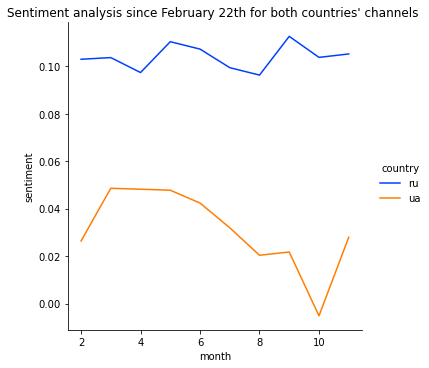

In [48]:
sns.relplot("month", "sentiment", data = df1_nn, kind = "line", hue = "country",palette='bright', ci = None ).set(title = "Sentiment analysis since February 22th for both countries' channels ")

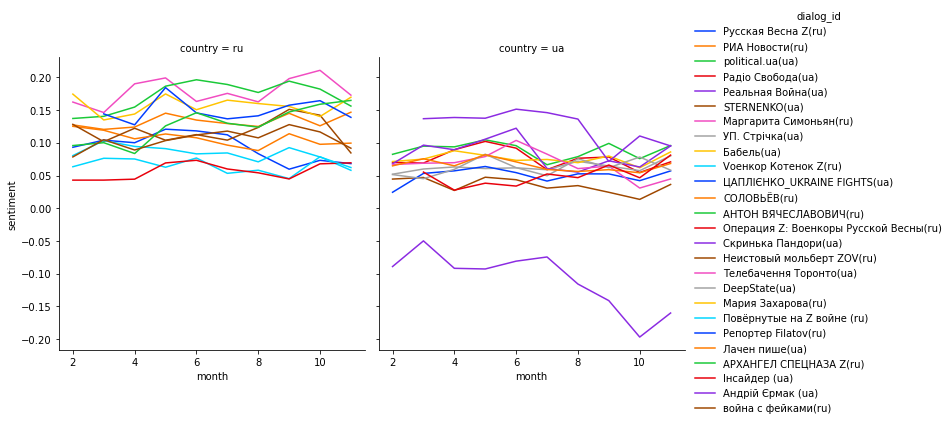

In [49]:
sns.relplot("month", "sentiment", data = df1_nn, kind = "line", hue = "dialog_id", col = "country", ci = None, palette = 'bright')

In russian channels we see that mostly, lines correspond to each, we see that text is a bit higher that neutral(but still, even with russian language it is hard to actually get the truth. For example, word "explosions" is considered as a negative word, but in the context of russian channels, sentence "explosions in Kyiv" is very positive, so mostly, in this part of the lab, I just realised how wrong I am, and how hard and interesting is to be a datascientist).
In ukrainian channels every channel is mostly at the same line(nearly neutral, not surprising), but we have one channel that is negative. And what's interesting, this channel is in russian, so we cannot blame it on poor ukrainian translation I gave here. Let's plot each ukrainian channel and try to investigate.

In [50]:
df2_nn = df1_nn.loc[df1_nn["country"] == "ua"]

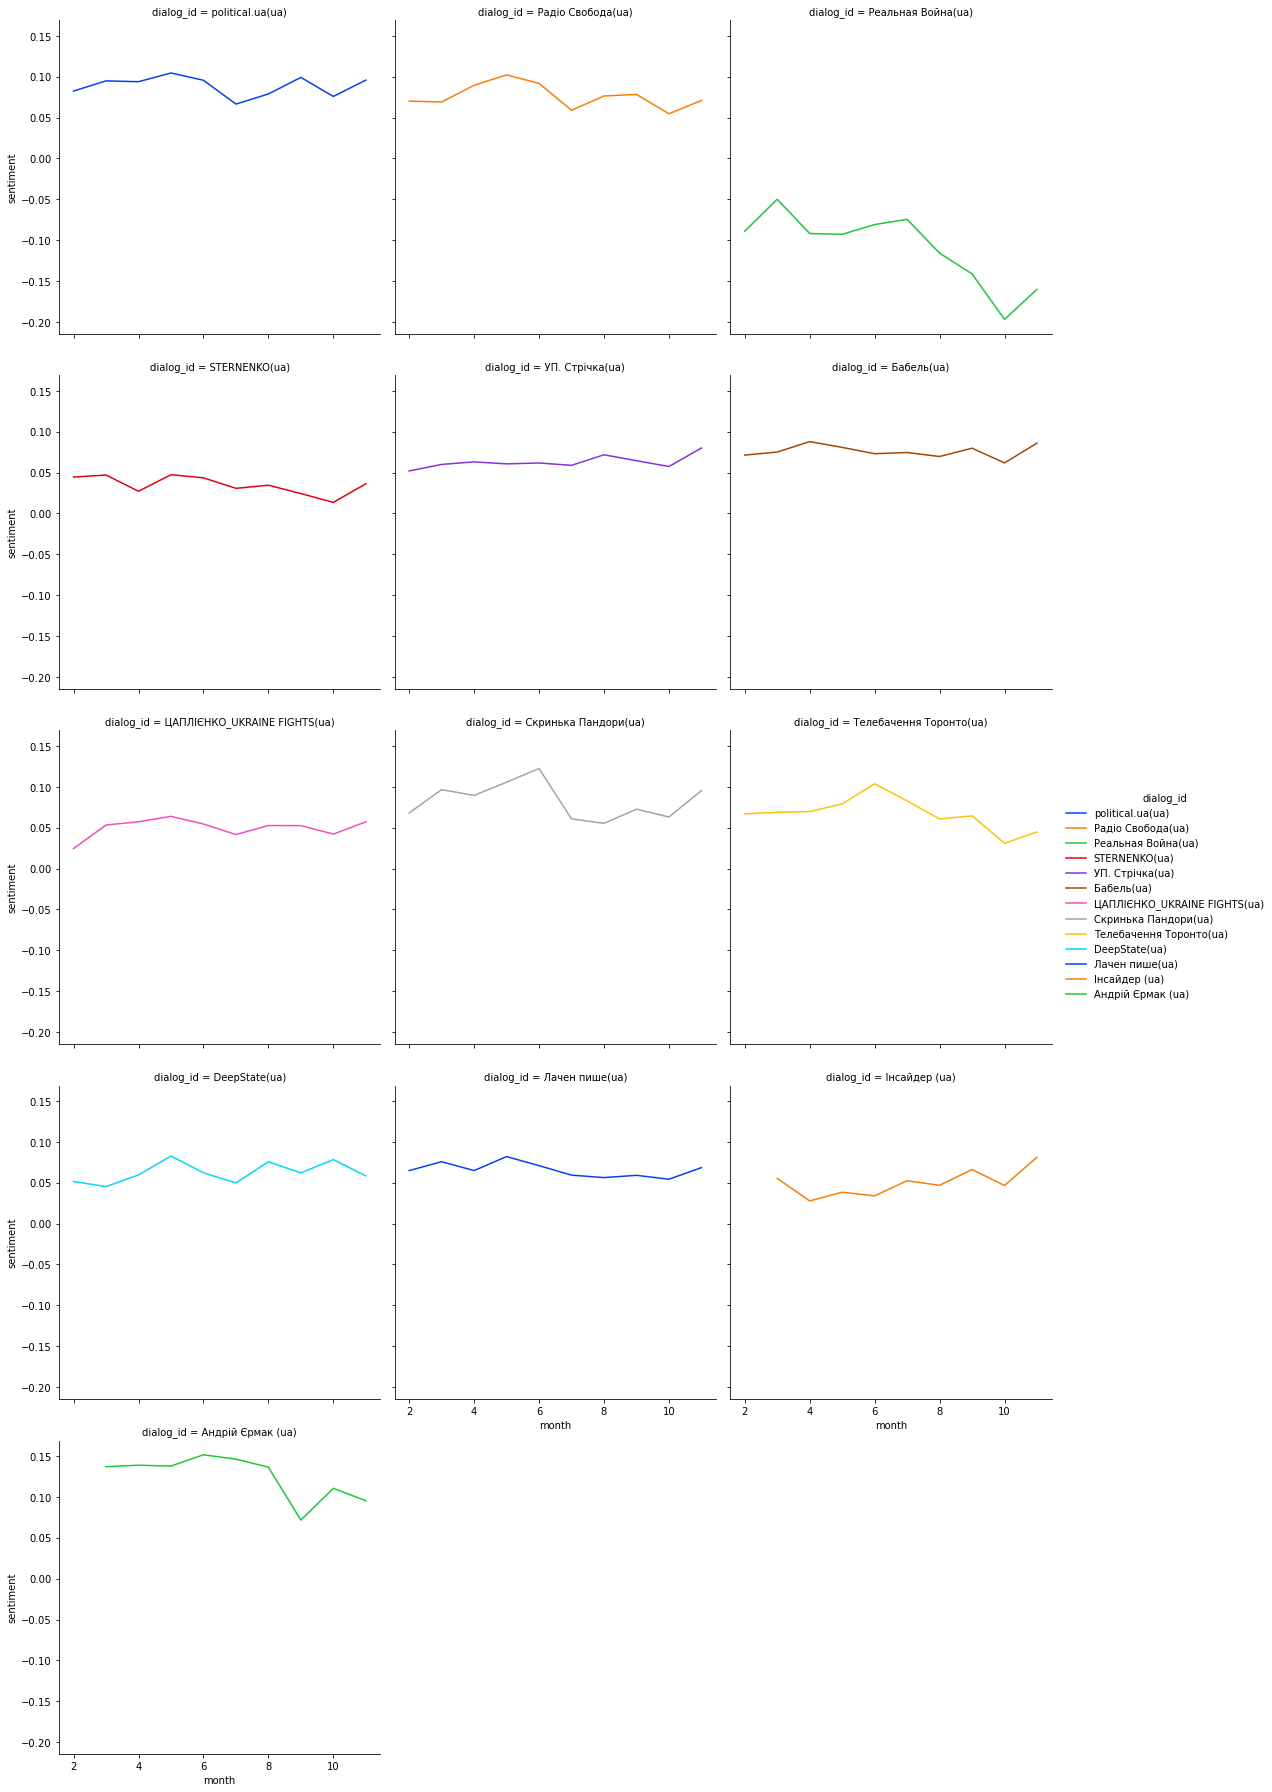

In [51]:
sns.relplot("month", "sentiment", data = df2_nn, kind = "line", hue = "dialog_id", col = "dialog_id", col_wrap = 3, ci = None, palette = 'bright')

So, the lowest one is "Реальная война", and it took me a lot to think, why especially this channels is so negative, and then I realised, that one of the reasons is them having a signature "реальная война" in practically every news, so + 1 negative word. If every other channel had that, they would probably get the same, as they are mostly neutral.
But still, we have some max and min, which corresponds to most of the channels. For example, it is easy to see huge sentiment pit(looking at Андрій Єрмак, Реальная война, Радіо Свобода, political.ua) at the beggining of the autumn, where, as we know from text analysis below, massive bombardings of Ukraine happened, so it still shows something.

##  Final conclusion

In this project I learned a lot of new skills( adequate usage of Groupby, lemmatization, tokenization, learned about stemming, learned how to use seaborn and performed very elementary yet still, sentiment analysis). It was extremely interesting to look at the war from the scientific(if we can say so) point of view, Sometimes, information was unpreditable, and trying to analyze why it is so, made me happy and miserable at the same time. Intersting experience. I also learned of theory about sentiment analysis, I did not performed it, but I read a lot and it was intersting, it is always great to see that you(and humanity in total) cannot do so many things so you have to investigate a lot and develop new skills to outcome yourself. It was very interesting and time consuming. 

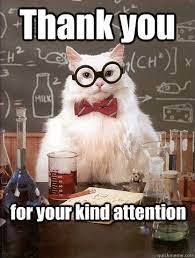
